##Modélisation énergétique sous OMEGAlpes

Représentation graphique du modèle énergétique avec le formalisme OMEGAlpes.

![PV_self_consumption_optim](figures/example_PV_self_consumption.png)

Tout d'abord, nous allons importer tous les élements nécessaires à la construction de notre modèle.

In [1]:
from python_scripts.NB_To_Modify_PV_self_consumption_utils import *

Un premier point pour étudier la stratégie de gestion énergétique optimale de cette
maison est d’introduire la dynamique associée au cas d’étude. Ici, nous choisirons d’étudier un scénario d’une période de 24 heures, au pas de temps de 5 minutes. De plus, le cas d’étude est appliqué à la journée du 10 août 2016. Ces informations nous permettent d’instancier notre classe *TimeUnit* comme suit :

In [2]:
time = TimeUnit(start='10/08/2016', periods=24*12, dt=1/12)

You are studying the period from 2016-08-10 00:00:00 to 2016-08-10 23:55:00


Ici, le nombre de périodes, défini par le paramètre *periods*, est de 24 heures au pas de temps 5 minutes, donc 24\*12 périodes. Le pas de temps *dt* est défini de façon horaire et fixé à 1 par défaut. Ainsi, notre pas de temps de 5 minutes est défini comme 1/12 d'heure. Il aurait également été possible de définir notre objet représentatif du temps en définissant des dates de début et de fin à la place du nombre de périodes. Par défaut, la date de début du problème est le 01/01/2018.

Ensuite, nous pouvons passer à la description énergétique du cas d'étude. Côté réseau électrique, l'import et l'export d'énergie ont été respectivement représentés par des unités de production et de consommation variables, puisque les flux énergétiques associés dépendront de la stratégie de consommation établie. Les lignes de code associées sont donc les suivantes :

In [3]:
exports = VariableConsumptionUnit(time, name="exports", 
                                  energy_type=elec)

Creating the exports.


In [4]:
imports = VariableProductionUnit(time, name="imports", p_max=6000,
                                 energy_type=elec)

Creating the imports.


À l'import énergétique du réseau électrique, s'ajoute la production solaire photovoltaïque (PV). Non pilotable, elle sera donc modélisée grâce à une unité de production fixe, en entrant son profil de production (PV_profile), comme suit :

In [5]:
PV_profile = import_PV_profile_5_min()

In [6]:
PV_prod = FixedProductionUnit(time, name="PV_prod", p=PV_profile, 
                              energy_type=elec)

Creating the PV_prod.


De façon similaire, la consommation d'eau chaude sanitaire est considérée comme connue sur l'ensemble de la journée. Cette unité peut donc être définie par une unité de consommation fixe, grâce au profil de consommation (dhw_load), avec la commande suivante :

In [7]:
dhw_load = import_domestic_hot_water_load_profile()
dhw = FixedConsumptionUnit(time, name="dhw", p=dhw_load,
                           energy_type=thermal)


Creating the dhw.


Les deux autres charges (électriques) sont considérées comme flexibles du point de vue du moment de démarrage. Les profils sont donc connus, mais peuvent cette fois être déplacés dans le temps. On utilisera les unités de consommation *ShiftableConsumptionUnit*, paramétrées par les profils respectifs de la machine à laver (washer_load) et du sèche-linge (dryer_load), comme suit :

In [8]:
washer_load = import_clothes_washer_load_profiles()
washer = ShiftableConsumptionUnit(time, name="washer", 
                                  power_values=washer_load,  
                                  energy_type=elec)


Creating the washer.


Dernière consommation électrique, le chauffe-eau électrique convertit de 90% de l'électricité consommée en énergie thermique. Il sera donc représenté par une unité de conversion énergétique, et plus particulièrement, une unité de conversion d'énergie électrique en énergie thermique avec un facteur de conversion constant, selon la ligne de code suivante :

In [9]:
water_heater = ElectricalToThermalConversionUnit(
    time, name="water_heater", elec_to_therm_ratio=0.9)

Creating the water_heater_therm_prod.
Creating the water_heater_elec_cons.
Creating the water_heater.


Enfin, il nous reste à intégrer le ballon d'eau chaude. Pour cela, nous nous appuierons sur un modèle simple de stockage d'une capacité de 6 kWh, ne devant pas se vider en-dessous de 20% de sa capacité et étant imposé à revenir à son état de charge initial à la fin de la journée. Nous ajouterons également un taux d'auto-décharge de 5% par heure. La formulation associée est la suivante :

In [10]:
water_tank = StorageUnit(time, name="water_tank",  self_disch=0.05, 
                         soc_min=0.2, energy_type=thermal,
                         ef_is_e0=True, capacity=6000, )

Creating the water_tank.


Une fois les unités énergétiques définies, elles peuvent être connectées entre elles par l'intermédiaire des noeuds énergétiques. Dans notre cas, nous avons un bilan  électrique et un bilan thermique, donc deux noeuds énergétiques, définis comme :

In [11]:
elec_node = EnergyNode(time, name="elec_node", 
                       energy_type=elec)

Creating the elec_node.


In [12]:
heat_node = EnergyNode(time, name="heat_node", 
                       energy_type=thermal)

Creating the heat_node.


La connexion des unités énergétiques aux noeuds associés se fait alors comme suit :

In [13]:
elec_node.connect_units(imports, exports, PV_prod, washer, 
                        water_heater.elec_consumption_unit)

In [14]:
heat_node.connect_units(dhw, water_tank, 
                        water_heater.thermal_production_unit)

### Ajout des contraintes externes et de l'objectif de modélisation


Désormais, nous souhaitons ajouter notre objectif : maximiser l'autoconsommation sur la journée, i.e. la part de la production d'électricité produite par les panneaux PV qui est consommée sur par la maison individuelle. Pour cela, nous cherchons donc à minimiser l'apport du réseau électrique et utiliserons donc la commande *minimize_production*, de la façon suivante :

In [15]:
imports.minimize_production()

### Lancement de l'optimisation et résultats

Maintenant que le modèle énergétique est prêt et que les contraintes et objectif ont été ajoutés, nous souhaitons réaliser l'optimisation.


La première étape est donc de créer le méta-modèle d'optimisation sous OMEGAlpes et d'y ajouter les noeuds énergétiques :


In [16]:
model = OptimisationModel(time, name="example")

In [17]:
model.add_nodes(elec_node, heat_node)






--- Adding all variables to the model ---
Adding variable : imports_p
Adding variable : imports_e_tot
Adding variable : imports_u
Adding variable : exports_p
Adding variable : exports_e_tot
Adding variable : exports_u
Adding variable : PV_prod_p
Adding variable : PV_prod_e_tot
Adding variable : washer_p
Adding variable : washer_e_tot
Adding variable : washer_u
Adding variable : washer_start_up
Adding variable : washer_power_values
Adding variable : water_heater_elec_cons_p
Adding variable : water_heater_elec_cons_e_tot
Adding variable : water_heater_elec_cons_u
Adding variable : water_heater_therm_prod_p
Adding variable : water_heater_therm_prod_e_tot
Adding variable : water_heater_therm_prod_u
Adding variable : dhw_p
Adding variable : dhw_e_tot
Adding variable : water_tank_p
Adding variable : water_tank_e_tot
Adding variable : water_tank_u
Adding variable : water_tank_capacity
Adding variable : water_tank_e
Adding variable : water_tank_pc
Adding variable : water_tank_pd
Adding variab

In [18]:
model.solve_and_update()


 - - - - - RUN OPTIMIZATION - - - - - 
Resolution duration = 9.636719703674316 seconds.

 - - - - - UPDATE RESULTS - - - - - 
Updating unit : elec_node
Updating unit : imports
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : exports
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : PV_prod
	Quantity : p
	Quantity : e_tot
Updating unit : washer
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : start_up
	Quantity : power_values
Updating unit : water_heater_elec_cons
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : water_heater
Updating unit : water_heater_therm_prod
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : heat_node
Updating unit : dhw
	Quantity : p
	Quantity : e_tot
Updating unit : water_tank
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f


Il est désormais possible de visualiser les résultats. Certaines commandes peuvent être directement utilisées en les importants du module *plots* : 


In [19]:
from omegalpes.general.utils.plots import *


Preparing to plot the energetic flows through the node elec_node.
	Add power from imports.
	Add power from exports.
	Add power from PV_prod.
	Add power from washer.
	Add power from water_heater_elec_cons.


<module 'matplotlib.pyplot' from 'C:\\Python3.6.0\\lib\\site-packages\\matplotlib\\pyplot.py'>

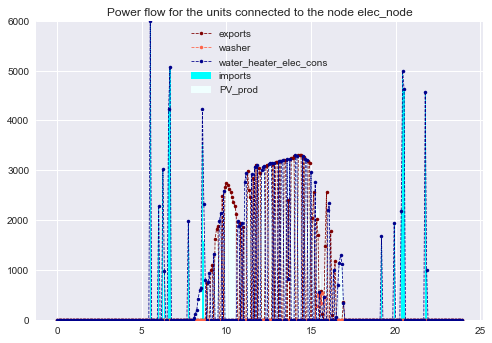

In [20]:
plot_node_energetic_flows(elec_node)

In [21]:
from omegalpes.general.utils.output_data import save_energy_flows

In [22]:
save_energy_flows(elec_node, heat_node, sep=';',
                  file_name='results/PV_example_results')
